In [10]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from matplotlib import pyplot
import tensorflow as tf
import numpy as np
np.random.seed(0)
import re
import os
import cv2

In [11]:
def lowResolution(path,sizeHigh,size):
    names = sorted(os.listdir(path))
    allLowImages = []
    for name in names:
        fpath = path + name
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        image=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        
        
        image = cv2.resize(image,(int(sizeHigh),int(sizeHigh)),cv2.INTER_CUBIC) 
        image = cv2.resize(image,(int(size),int(size)),cv2.INTER_CUBIC) 
        lowimage=image[:, :, :].astype(float) / 255 
        
        allLowImages.append(lowimage) 
    allLowImages = np.array(allLowImages)
    return allLowImages

In [12]:
def highResolution(path,size):
    names = sorted(os.listdir(path))
    allHighimages = []
    for name in names:
        fpath = path + name
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        image=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #change bgr to rgb
        
        highimage = cv2.resize(image,(size,size),cv2.INTER_CUBIC) 
        highimage=highimage[:, :, :].astype(float) / 255 
        
        allHighimages.append(highimage) 
    allHighimages = np.array(allHighimages)
    return allHighimages

In [13]:
input_img = Input(shape=(None, None, 3))
l1 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(input_img)

l2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding = 'same')(l2)   
l3 = Dropout(0.3)(l3)

l4 = Conv2D(128, (3, 3),  padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l3)

l5 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding = 'same')(l5) #2

l7 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l6)
l8 = Conv2DTranspose(256, (2,2), strides=(2,2))(l7)

l9 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
            activity_regularizer = regularizers.l1(10e-10))(l8)

l10 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l9)     # 2  /   2 

l11 = add([l5, l10])
l12 = Conv2DTranspose(128, (2,2), strides=(2,2))(l11)

l13 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l12)

l14 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])
postUpsampling= Conv2DTranspose(64, (2,2), strides=(2,2))(l15)

decoded = Conv2D(3, (3, 3), padding = 'same', 
                 activation = 'relu', activity_regularizer = regularizers.l1(10e-10))(postUpsampling)


autoencoder = Model(input_img, decoded)

In [14]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_20 (Conv2D)             (None, None, None,   1792        ['input_3[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, None, None,   36928       ['conv2d_20[0][0]']              
                                64)                                                         

In [15]:
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics='accuracy')

In [16]:
x_train_low=lowResolution("./data/DIV2K_train_HR/",512,256)

In [17]:
x_train_high=highResolution("./data/DIV2K_train_HR/",512)

In [18]:
print(x_train_low.shape)

(900, 256, 256, 3)


In [19]:
print(x_train_high.shape)

(900, 512, 512, 3)


Text(0.5, 1.0, 'high resolution ')

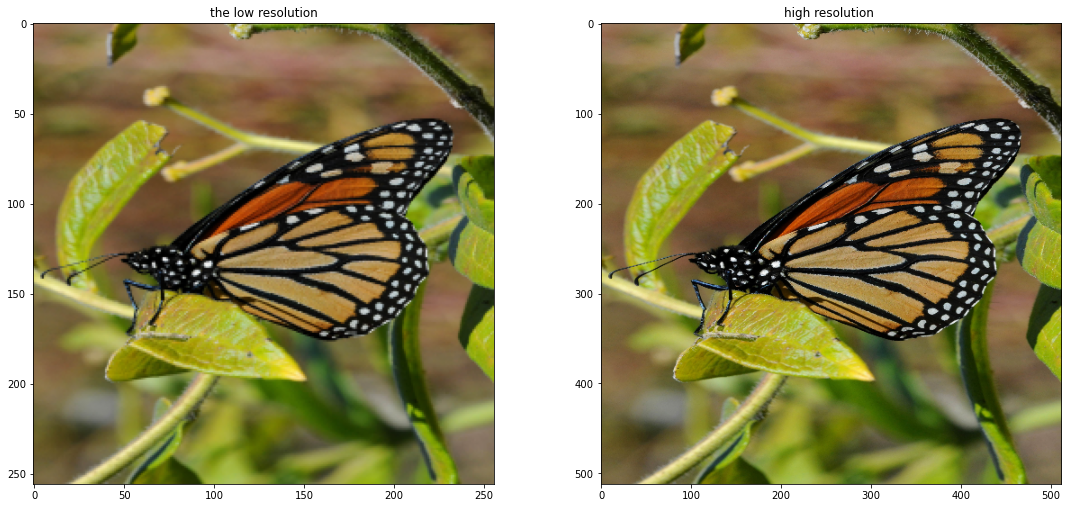

In [20]:
plt.figure(figsize = (100, 100))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_low[5])
plt.title("the low resolution")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_high[5])
plt.title("high resolution ")

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [22]:
history=autoencoder.fit(x_train_low, x_train_high,epochs=120,batch_size=10,shuffle=True, callbacks=[callback],validation_split=0.2)

Epoch 1/120
72/72 [==============================] - 808s 11s/step - loss: 0.0613 - accuracy: 0.5059 - val_loss: 0.0092 - val_accuracy: 0.6603
Epoch 2/120
72/72 [==============================] - 805s 11s/step - loss: 0.0072 - accuracy: 0.7859 - val_loss: 0.0054 - val_accuracy: 0.8466
Epoch 3/120
72/72 [==============================] - 805s 11s/step - loss: 0.0053 - accuracy: 0.8619 - val_loss: 0.0047 - val_accuracy: 0.8574
Epoch 4/120
72/72 [==============================] - 805s 11s/step - loss: 0.0049 - accuracy: 0.8679 - val_loss: 0.0045 - val_accuracy: 0.8619
Epoch 5/120
72/72 [==============================] - 806s 11s/step - loss: 0.0048 - accuracy: 0.8722 - val_loss: 0.0044 - val_accuracy: 0.8671
Epoch 6/120
72/72 [==============================] - 806s 11s/step - loss: 0.0046 - accuracy: 0.8790 - val_loss: 0.0043 - val_accuracy: 0.8714
Epoch 7/120
72/72 [==============================] - 806s 11s/step - loss: 0.0045 - accuracy: 0.8844 - val_loss: 0.0042 - val_accuracy: 0.8653

Epoch 58/120
72/72 [==============================] - 807s 11s/step - loss: 0.0037 - accuracy: 0.9148 - val_loss: 0.0034 - val_accuracy: 0.9003
Epoch 59/120
72/72 [==============================] - 807s 11s/step - loss: 0.0037 - accuracy: 0.9121 - val_loss: 0.0034 - val_accuracy: 0.9031
Epoch 60/120
72/72 [==============================] - 806s 11s/step - loss: 0.0037 - accuracy: 0.9128 - val_loss: 0.0034 - val_accuracy: 0.8862
Epoch 61/120
72/72 [==============================] - 807s 11s/step - loss: 0.0038 - accuracy: 0.8938 - val_loss: 0.0035 - val_accuracy: 0.8717
Epoch 62/120
72/72 [==============================] - 808s 11s/step - loss: 0.0037 - accuracy: 0.9052 - val_loss: 0.0034 - val_accuracy: 0.9085
Epoch 63/120
72/72 [==============================] - 805s 11s/step - loss: 0.0037 - accuracy: 0.9129 - val_loss: 0.0034 - val_accuracy: 0.9085
Epoch 64/120
72/72 [==============================] - 806s 11s/step - loss: 0.0036 - accuracy: 0.9144 - val_loss: 0.0034 - val_accuracy:

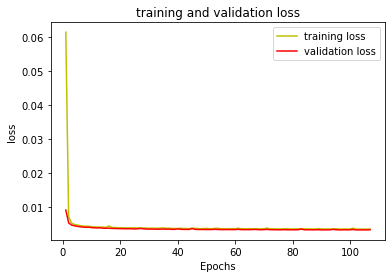

In [23]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

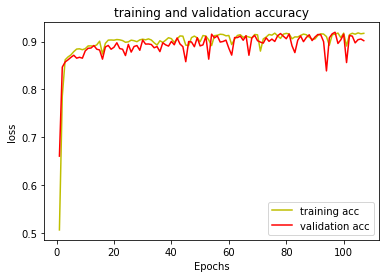

In [24]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label="training acc")
plt.plot(epochs,val_acc,'r',label="validation acc")
plt.title("training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [25]:
print(history.history)

{'loss': [0.06133566424250603, 0.007194099016487598, 0.005332510452717543, 0.00493409251794219, 0.004776877351105213, 0.004570786375552416, 0.004470300395041704, 0.004390599671751261, 0.0043860855512320995, 0.004292221739888191, 0.004224285949021578, 0.004182172939181328, 0.004164930433034897, 0.004134180024266243, 0.004069943446666002, 0.004497791174799204, 0.004045157227665186, 0.004007263109087944, 0.003981884103268385, 0.003965449519455433, 0.003945734351873398, 0.003926604054868221, 0.003924362361431122, 0.003930169157683849, 0.003937975503504276, 0.0038876142352819443, 0.0039025857113301754, 0.0038964294362813234, 0.003849657019600272, 0.0038223406299948692, 0.00383983482606709, 0.0038158558309078217, 0.0038040406070649624, 0.0038692408706992865, 0.003921244293451309, 0.003805649932473898, 0.00380502175539732, 0.0037697695661336184, 0.0037449512165039778, 0.0037516087759286165, 0.003839140525087714, 0.0037325285375118256, 0.00371841830201447, 0.0037161109503358603, 0.003844720078

In [26]:
autoencoder.save('Autencoder_Deconv_0ep120.h5') 